# Gradient Descent

**Overview**

- The code is an implementation of a linear regression model to predict the housing prices using the kc_house dataset can found [here](https://raw.githubusercontent.com/nagensk9/INDE577_ML/main/Dataset/Regression/kc_house_data.csv).
- In this case, the **target variable** is the **housing price**, while the **features** are the number of **bedrooms, bathrooms, living area, lot area, floors, waterfront, view, condition, and grade** of the property.

- The code uses the popular scikit-learn library for machine learning in Python to preprocess the data, split it into train and test sets, train the , and evaluate its performance. The evaluation metrics used in the code include R-squared value, mean squared error, mean absolute error, and root mean squared error.

In [ ]:
# Import the required libraries for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the required libraries for machine learning
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.model_selection import learning_curve


#### Data

In [ ]:
# Set the dataset URL
url = "https://raw.githubusercontent.com/nagensk9/INDE577_ML/main/Dataset/Regression/kc_house_data.csv"

In [ ]:
def load_data(url):
    """
    Loads data from a given url into a pandas dataframe.
    """
    df = pd.read_csv(url)
    return df

#### Data Cleaning and Pre Processing

In [ ]:
def clean_data(df):
    """
    Cleans the given dataframe by removing rows with incorrect data
    and dropping unnecessary columns.
    """
    # Remove rows with incorrect data
    df = df.drop(df[(df['bedrooms'] == 33) & (df['bathrooms'] == 1.75)].index)
    df = df.drop(df[(df['bedrooms'] == 0) & (df['price'] == 1095000)].index)
    df = df.drop(df[(df['bedrooms'] == 0) & (df['price'] == 380000)].index)
    df = df.drop(df[(df['bedrooms'] == 33) & (df['sqft_living'] == 1620)].index)
    df = df.drop(df[(df['sqft_lot'] == 1600000) & (df['bathrooms'] == 1) & (df['sqft_living'] == 1600)].index)

    # Drop the "id" and "date" columns
    df = df.drop(['id', 'date', 'zipcode'], axis=1)

    # Drop 1% of data to make price column normally distrubted
    df = df.sort_values(['price'], ascending=False).iloc[200:]


    return df

#### Model Performance Plots

In [ ]:
def plot_predictions(y_test, y_pred):
    """
    Plots the actual vs predicted values.
    """
    plt.scatter(y_test, y_pred, c=['b']*len(y_test), alpha=0.5)
    plt.scatter(y_test, y_test, c=['r']*len(y_test), alpha=0.5)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs Predicted Prices")
    plt.show()

In [ ]:
def plot_residuals(y_test, y_pred):
    """
    Plots the residuals of the model.
    """
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title("Residual Plot")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals")
    plt.show()

#### Implementation

In [ ]:
# Load the dataset
df = load_data(url)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
# Clean the data
df = clean_data(df)

In [ ]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
15039,2000000.0,3,3.25,2610,16387,2.0,1,4,3,9,2610,0,2006,0,47.7175,-122.278,2590,12958
10468,2000000.0,4,3.75,2870,4500,2.0,0,3,3,10,2510,360,2012,0,47.6291,-122.363,2870,6354
21,2000000.0,3,2.75,3050,44867,1.0,0,4,3,9,2330,720,1968,0,47.5316,-122.233,4110,20336
13271,2000000.0,4,3.00,4260,18000,2.0,0,2,3,11,4260,0,2000,0,47.5355,-122.240,3540,17015
4486,2000000.0,5,4.00,4580,4443,3.0,1,4,3,10,4580,0,2004,0,47.5682,-122.059,2710,4443


#### Build Model

In [ ]:
def compute_cost(X, y, theta):
    """
    Computes the mean squared error for a given set of parameters.
    """
    m = len(y)
    J = np.sum((X.dot(theta) - y) ** 2) / (2 * m)
    return J


In [ ]:
# define the gradient function
def gradient_function(X, y, theta):
    m = len(y)
    h = X.dot(theta)
    grad = (1 / m) * X.T.dot(h - y)
    return grad

In [ ]:
def gradient_descent(X, y, theta, alpha, iterations, batch_size):
    """
    Performs gradient descent for a given number of iterations.
    """
    m = len(y)
    cost_history = []
    grad_magnitude_history = []
    for i in range(iterations):

        # calculate the gradient vector using the gradient function
        gradient = gradient_function(X, y, theta)
        
        # calculate the magnitude of the gradient vector
        grad_magnitude = np.linalg.norm(gradient)
        
        # update the theta values using the learning rate and gradient vector
        theta -= alpha * gradient
        
        # calculate the cost using the cost function and append it to the cost history list
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
        
        # append the gradient magnitude to the grad magnitude history list
        grad_magnitude_history.append(grad_magnitude)
        
    return theta, cost_history, grad_magnitude_history


In [ ]:
# extract the relevant features
X = df.iloc[:,1:].values
y = df['price'].values

# normalize the data
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X = (X - mu) / sigma

# add a column of ones for the intercept term
X = np.hstack((np.ones((X.shape[0], 1)), X))

#scaling the data
sc1=StandardScaler()
X = sc1.fit_transform(X)

sc2=StandardScaler()
y = np.ravel(sc2.fit_transform(y.reshape(-1,1)))


# set the learning rate and number of iterations
alpha = 0.01
iterations = 1000

# initialize the parameter vector
theta = np.zeros(X.shape[1])

# define the batch size
batch_size = 32


In [ ]:
# perform gradient descent
theta, cost_history, grad_magnitude_history = gradient_descent(X, y, theta, alpha, iterations, batch_size)

In [ ]:
# Print final parameters
print("Final parameters:", theta)

Final parameters: [ 0.         -0.056685    0.07623546  0.16951033  0.0331326   0.04219055
  0.07055128  0.11143712  0.07519287  0.35176709  0.15067299  0.06233188
 -0.20374815  0.03571522  0.27100097 -0.04221492  0.12573743 -0.02390976]


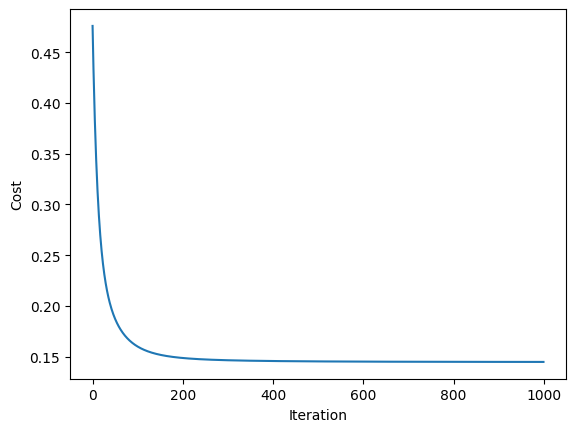

In [ ]:
# plot the cost history
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

In [ ]:
# calculate predictions
y_pred = X.dot(theta)

# calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.2896586667016237
Root Mean Squared Error: 0.5381994673925493


In [ ]:
# Calculate R-squared
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

R-squared: 0.7103413332983763


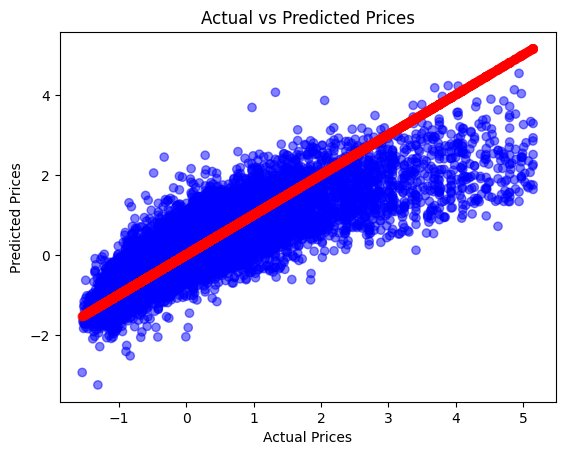

In [ ]:
plot_predictions(y, y_pred)

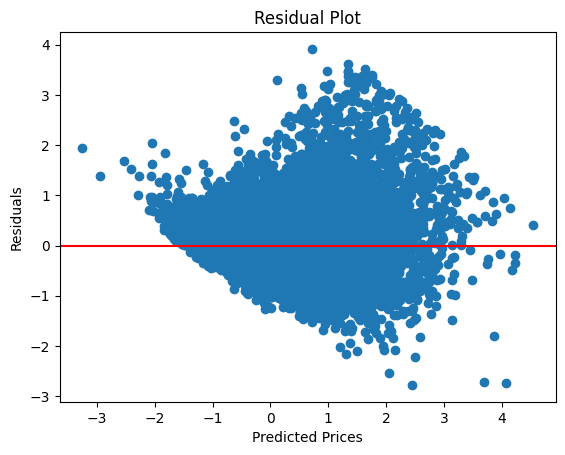

In [ ]:
plot_residuals(y, y_pred)

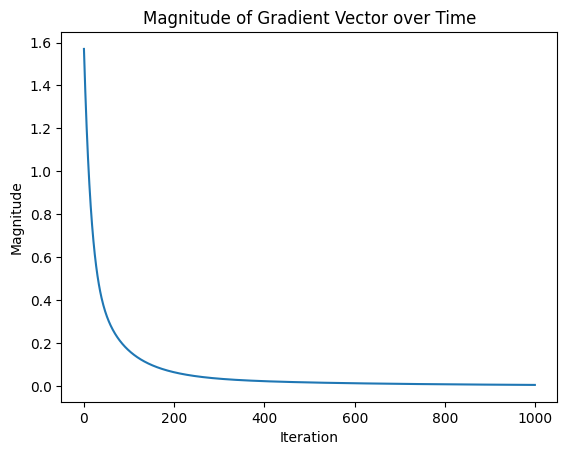

In [ ]:
# plot the magnitude of the gradient vector over time
plt.plot(grad_magnitude_history)
plt.title("Magnitude of Gradient Vector over Time")
plt.xlabel("Iteration")
plt.ylabel("Magnitude")
plt.show()

### Stochastic Gradient

In [ ]:
def stochastic_gradient_descent(X, y, alpha, iterations, batch_size, theta):
    m, n = X.shape
    cost_history = []
    for i in range(iterations):
        for j in range(0, m, batch_size):
            X_batch = X[j:j+batch_size]
            y_batch = y[j:j+batch_size]
            gradient = gradient_function(X_batch, y_batch, theta)
            theta -= alpha * gradient
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history

# Set hyperparameters
alpha = 0.01
iterations = 1000
batch_size = 32

# initialize the parameter vector
theta = np.zeros(X.shape[1])




In [ ]:
theta

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [ ]:
# Perform stochastic gradient descent
theta, cost_history = stochastic_gradient_descent(X, y, alpha, iterations, batch_size, theta)

In [ ]:
# Print final parameters
print("Final parameters:", theta)

Final parameters: [ 0.         -0.0399239   0.05743602  0.15877603  0.05081768  0.04314098
  0.05311453  0.11322583  0.05548801  0.2639881   0.14651307  0.04847299
 -0.1080155   0.01341009  0.23372594  0.04431517  0.14462383  0.01057957]


In [ ]:
# calculate predictions
y_pred = X.dot(theta)

# calculate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.32449326625916436
Root Mean Squared Error: 0.5696431042847481


In [ ]:
# Calculate R-squared
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

R-squared: 0.6755067337408356


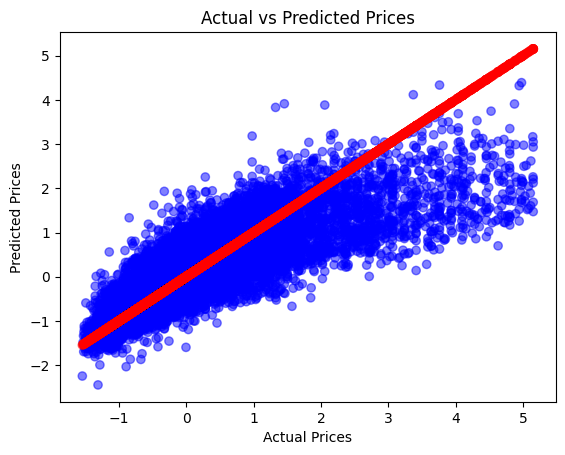

In [ ]:
plot_predictions(y, y_pred)